In [108]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-09-21 18:00:45,976: Credentials are already in use. The existing account in the session will be replaced.


In [109]:
## INPUTS

names = ['sergio', 'carmen', 'adrian', 'alfonso']

participants = {'00': ['Sergio', 'Eat sandwiches and drink beer'], 
                '01': ['Carmen', 'Learn Quantum Computing with other people'], 
                '10': ['Adrian', 'Improve my german skills'], 
                '11': ['Alfonso', 'Increase my knowledge of Quantum']}


In [121]:
qubits = 2
feed_keywords = ['knowledge', 'learn', 'learning', 'discover']
opinion = []

for participant in participants:
    num = 0
    for i in feed_keywords:
        num += participants[participant][1].lower().count(i.lower())

    if(num > 0):
        opinion.append(0)
    else:
        opinion.append(1)
        
print(opinion)



[1, 0, 1, 0]


In [111]:
def add_oracle(circuit, qubits, number):
    ctrls = np.binary_repr(number, width=qubits)
    for i, c in enumerate(ctrls):
        if c == '1':
            circuit.x(qubits - i - 1)
    
    circuit.mct(list(range(qubits)), qr_opinion[0])
            
    for i, c in enumerate(ctrls):
        if c == '1':
            circuit.x(qubits - i - 1)
    

In [112]:
def circuit(C, qubits, opinion):
    for q in range(qubits):
        C.h(q)
    for i, o in enumerate(opinion):
        if o == 1:
            add_oracle(C, qubits, i)
    C.barrier()
            
def circuit_inverse(C, qubits, opinion):
    opinion.reverse()
    for i, o in enumerate(opinion):
        if o == 1:
            add_oracle(C, qubits, 2**qubits - 1 - i)
    for q in range(qubits):
        C.h(q)
    opinion.reverse()
    C.barrier()
            
def oracle(C):
    C.z(qr_opinion)
    C.barrier()
    
def diffusion(C, qubits):
    C.h(qr_opinion)
    C.mct(list(range(qubits)), qr_opinion[0])
    C.h(qr_opinion)
    C.barrier()

In [113]:
def create_circuit(qubits, iterations, opinion, beers=True):
    C = QuantumCircuit()

    qr_people = QuantumRegister(qubits,'people')
    cr_people = ClassicalRegister(qubits, 'c_people')
    C.add_register(qr_people)
    C.add_register(cr_people)

    qr_opinion = QuantumRegister(1, 'opinion')
    cr_opinion = ClassicalRegister(1, 'c_opinion')
    C.add_register(qr_opinion)
    C.add_register(cr_opinion)

    qr_beer = QuantumRegister(1, 'beer')
    cr_beer = ClassicalRegister(1, 'c_beer')
    C.add_register(qr_beer)
    C.add_register(cr_beer)
    
    
    if beers:
        C.h(qr_beer)
        C.barrier()
        
    circuit(C, qubits, opinion)
    
    for i in range(iterations):
        oracle(C)
        circuit_inverse(C, qubits, opinion)
        diffusion(C, qubits)
        circuit(C, qubits, opinion)
        
    if beers:
        C.barrier()
        C.h(qr_beer)
        
    for i in range(qubits + 2):
        C.measure(i,i)
        
    return C

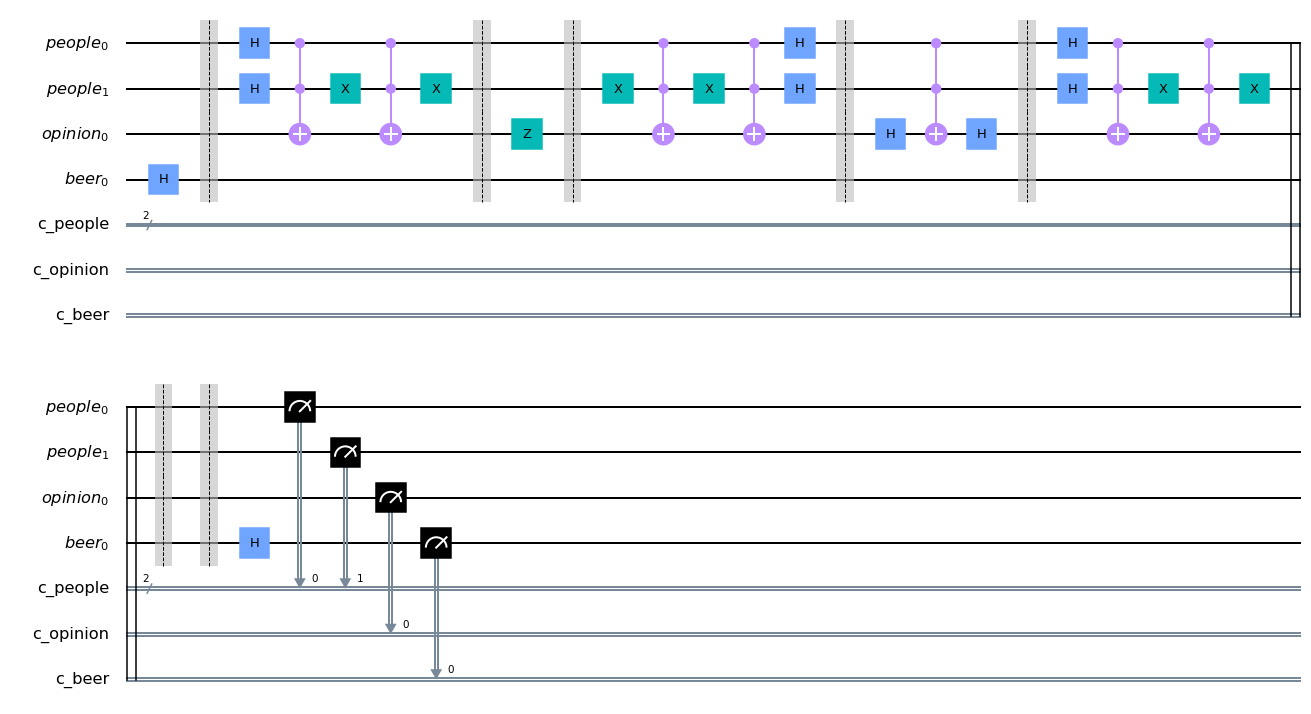

In [122]:
repetitions = 1
C = create_circuit(qubits, repetitions, opinion)

C.draw('mpl')

In [170]:
noisy_backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(noisy_backend)
T1 = 0.001
T2 = 0.002
error = 0.001
thermal_error = thermal_relaxation_error(T1, T2, error)
noise_model.add_quantum_error(thermal_error, "h", [qubits+1])

{'0 0 00': 896, '0 0 01': 56, '0 0 10': 822, '0 0 11': 39, '0 1 00': 42, '0 1 01': 911, '0 1 10': 33, '0 1 11': 878, '1 0 00': 76, '1 0 01': 1, '1 0 10': 87, '1 1 00': 4, '1 1 01': 77, '1 1 10': 8, '1 1 11': 70}


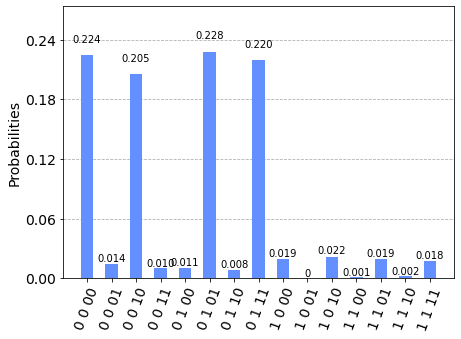

In [171]:
simulator = Aer.get_backend('qasm_simulator') 
shots = 4000
job_noisy = execute(C, simulator, shots=shots, noise_model=noise_model)
result_noisy = job_noisy.result()
counts_noisy = result_noisy.get_counts(C)
print(counts_noisy); # print the results of the runs
plot_histogram(counts_noisy) # Visualise the results

In [172]:
noise_model.to_dict

<bound method NoiseModel.to_dict of NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'id', 'measure', 'h', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [2, 3]), ('cx', [3, 2]), ('cx', [3, 4]), ('cx', [4, 3]), ('h', [3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]>

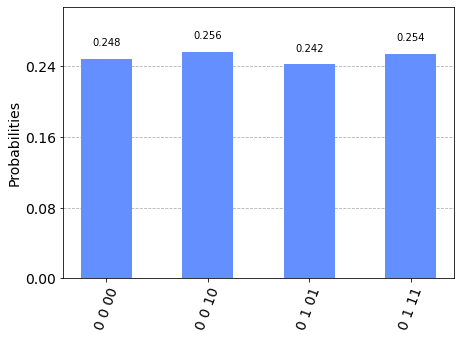

In [173]:
job_noiseless = execute(C, simulator, shots=shots)
result_noiseless = job_noiseless.result()
counts_noiseless = result_noiseless.get_counts(C)
plot_histogram(counts_noiseless)

In [178]:
for c in counts_noisy:
    result = c.split()
    if(result[1] == '1' and counts_noisy[c] / shots > 0.2):
        print(participants[result[2]][0], "you are awesome! You are invited to the next one!")
    if(result[0] == '1' and counts_noisy[c] / shots >= 0.01):
        print(participants[result[2]][0],", you also have a beer!")

Carmen you are awesome! You are invited to the next one!
Alfonso you are awesome! You are invited to the next one!
Sergio , you also have a beer!
Adrian , you also have a beer!
Carmen , you also have a beer!
Alfonso , you also have a beer!


In [126]:
opinion

[1, 0, 1, 0]